In [ ]:
from sklearn.preprocessing import OneHotEncoder
from utils_public import *
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models

# Load data
grids = load_grids()
ratings = np.load("datasets/scores.npy")
ratings_df = pd.DataFrame(ratings, columns=["Wellness", "Tax", "Transportation", "Business"])

advisor = 0 #select advisor 0 for now. 
grids_subset, ratings_subset = select_rated_subset(grids, ratings[:,advisor]) #gets subset of the dataset 
X_train, X_validation, Y_train, Y_validation = train_test_split(grids_subset, ratings_subset, test_size=.2, random_state=42)

# Data parameters
num_samples = 4000
height, width = 7, 7
num_pixel_classes = 5  # pixels take values 0 to 4
# # One-hot encoding of categorical pixel values
X_train_encoded = tf.one_hot(X_train, depth=num_pixel_classes)  # Shape: (4000, 7, 7, 5)
X_validation_encoded = tf.one_hot(X_validation, depth=num_pixel_classes)  # Shape: (4000, 7, 7, 5)



In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchsummary import summary

import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from tqdm import tqdm, trange
import seaborn as sns
import pandas as pd

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
def train_model(model, X_train, Y_train, X_validation, Y_validation, num_epochs=10, batch_size=32, learning_rate=0.001, device='cuda'):
    """
    Function to train a given model (CNN or DNN) using training and validation data.

    Args:
    - model: The model to train (e.g., CNN or DNN).
    - X_train: Training data (features).
    - Y_train: Training data (labels).
    - X_validation: Validation data (features).
    - Y_validation: Validation data (labels).
    - num_epochs: Number of training epochs (default: 10).
    - batch_size: Batch size for training (default: 32).
    - learning_rate: Learning rate for the optimizer (default: 0.001).
    - device: Device to run the model on ('cuda' or 'cpu').

    Returns:
    - train_losses: List of training losses for each epoch.
    - val_losses: List of validation losses for each epoch.
    """

    # Move model to the specified device (GPU or CPU)
    model = model.to(device)

    # Define loss function (Mean Squared Error for regression tasks)
    criterion = nn.MSELoss()

    # Define optimizer (Adam optimizer with specified learning rate)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Create DataLoader for batching the training data
    train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(Y_train, dtype=torch.float32))
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    # Create DataLoader for batching the validation data
    validation_dataset = TensorDataset(torch.tensor(X_validation, dtype=torch.float32), torch.tensor(Y_validation, dtype=torch.float32))
    validation_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)

    # Lists to store train and validation losses
    train_losses = []
    val_losses = []

    # Training loop
    for epoch in range(num_epochs):
        model.train()  # Set model to training mode
        running_loss = 0.0

        # Using tqdm for the training loop progress bar
        train_loader_tqdm = tqdm(train_loader, desc=f'Epoch [{epoch + 1}/{num_epochs}]', leave=False)

        # Iterate over batches of training data
        for inputs, labels in train_loader_tqdm:
            inputs = inputs.to(device)  # Move inputs to device (GPU/CPU)
            labels = labels.to(device)  # Move labels to device (GPU/CPU)

            # Zero the gradients before the next update
            optimizer.zero_grad()

            # Forward pass: compute model outputs
            outputs = model(inputs)

            # Compute the loss
            loss = criterion(outputs, labels)

            # Backward pass: compute gradients
            loss.backward()

            # Perform a single optimization step (update model parameters)
            optimizer.step()

            # Accumulate loss over the batch
            running_loss += loss.item() * inputs.size(0)

            # Update tqdm progress bar with current loss
            train_loader_tqdm.set_postfix({'Train Loss': running_loss / len(train_loader.dataset)})

        # Calculate average training loss for the epoch
        epoch_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_loss)

        # Validation loop (no gradient computation)
        model.eval()  # Set model to evaluation mode
        val_loss = 0.0
        with torch.no_grad():
            for inputs, labels in validation_loader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Forward pass: compute model outputs
                outputs = model(inputs)

                # Compute validation loss
                loss = criterion(outputs, labels)
                val_loss += loss.item() * inputs.size(0)

        # Calculate average validation loss for the epoch
        val_loss /= len(validation_loader.dataset)
        val_losses.append(val_loss)

        # Print the train and validation loss at the end of each epoch
        print(f'Epoch [{epoch + 1}/{num_epochs}] - Train MSE: {epoch_loss:.4f} - Validation MSE: {val_loss:.4f}')

    print("Training complete.")

    # Return the recorded training and validation losses
    return train_losses, val_losses


In [ ]:
class CNN(nn.Module):
    def __init__(self):  # Define all the layers here
        super(CNN, self).__init__()
        # All pooling will use 2x2 window and stride 2
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # First Conv layer: 1 input channel (grayscale), 4 output channels, kernel size 3x3, stride 1, padding 1
        self.conv1 = nn.Conv2d(1, 4, kernel_size=3, stride=1, padding=1)

        # Second Conv layer: 4 input channels, 8 output channels
        self.conv2 = nn.Conv2d(4, 8, kernel_size=3, stride=1, padding=1)

        # Third Conv layer: 8 input channels, 16 output channels
        self.conv3 = nn.Conv2d(8, 16, kernel_size=3, stride=1, padding=1)

        # Fourth Conv layer: 16 input channels, 32 output channels
        self.conv4 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)

        # Operation to flatten the images into a vector
        self.flatten = nn.Flatten()

        # Fully connected layers
        self.fc1 = nn.Linear(32 * 3 * 3, 16)  # Adjusted to match the output size after conv3
        self.fc2 = nn.Linear(16, 1)  # 5 output classes

    def forward(self, x):  # Call all the layers in this function
        # Reshape the input to ensure it has the correct channel dimension: [batch x 1 x 50 x 50]
        if len(x.shape) == 3:  # Input is [batch x 50 x 50]
            x = x.unsqueeze(1)  # Add channel dimension -> [batch x 1 x 50 x 50]

        # Convolve, then pass through ReLU, then pooling
        x = F.relu(self.conv1(x))  # [batch x 4 x 50 x 50]
        x = self.pool(x)  # [batch x 4 x 25 x 25]

        x = F.relu(self.conv2(x))  # [batch x 8 x 25 x 25]
        x = self.pool(x)  # [batch x 8 x 12 x 12]

        x = F.relu(self.conv3(x))  # [batch x 16 x 12 x 12]
        x = self.pool(x)  # [batch x 16 x 6 x 6]

        x = F.relu(self.conv4(x))  # [batch x 32 x 6 x 6]
        x = self.pool(x)  # [batch x 32 x 3 x 3]

        x = self.flatten(x)  # Flatten for the fully connected layer [batch x 288]

        # Pass through fully connected layers with ReLU
        x = F.relu(self.fc1(x))  # [batch x 16]

        # Final fully connected layer with no activation (since we are doing regression)
        x = self.fc2(x)  # Output layer with 5 outputs [batch x 5]
        return x

# Create a CNN model instance
model_cnn = CNN()
model_cnn.to(device)

# Print the model's architecture
summary(model_cnn, input_size=(1, 50, 50))  # Adjusted input size for grayscale images with 1 channel

In [ ]:


# Regression target is continuous value (for example)
# Create dummy regression targets (replace with your actual target)
# y = np.random.rand(num_samples, 1)  # shape (4000, 1)

# # Simulate input data: 4000 images with pixel categories 0-4
# X = np.random.randint(0, num_pixel_classes, size=(num_samples, height, width))


# Build CNN model for regression
model = models.Sequential([
    layers.Input(shape=(height, width, num_pixel_classes)),
    layers.Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(1, activation='linear')  # Single output for regression
])

# Compile model with mean squared error loss for regression
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Train the model (using 20% data for validation)
model.fit(X_encoded, Y_train, batch_size=32, epochs=20, validation_split=0.2)

# X_train, X_validation, Y_train, Y_validation

125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 896us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1000us/step


ValueError: x and y must be the same size

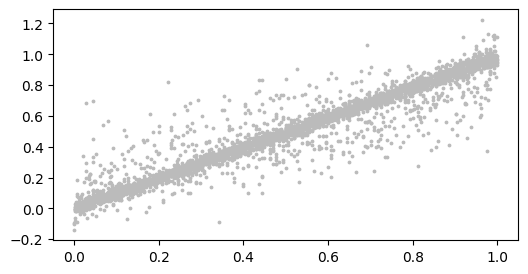

In [ ]:
from sklearn.metrics import r2_score
def plot_and_r2(preds_train, preds_test, ratings_train, ratings_test, advisor): 
    #Calculates 
    plt.figure(figsize=(6,3))
    plt.scatter(ratings_train, preds_train, label='Train Set Preds', s=3, c = "#BBBBBB") #train set in gray
    plt.scatter(ratings_test, preds_test, label='Test Set Preds', s=5, c = "#DC267F") #test set in magenta
    plt.plot([0,1], [0,1], label="Target", linewidth=3, c="k") #target line in black

    #Set axis labels and title
    plt.xlabel("Actual Rating")
    plt.ylabel("Predicted Rating")
    plt.title(f"Advisor {advisor} Predictions")

    #Turn off top and right spines
    ax = plt.gca()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    plt.legend() #Display legend
    plt.show() #Show plot

    #Calculate R2 score for train and test sets
    print(f"Advisor {advisor} Train Set R2 score: {r2_score(ratings_train, preds_train)}") 
    print(f"Advisor {advisor} Test Set R2 score: {r2_score(ratings_test, preds_test)}")


preds_train = model.predict(X_train_encoded) #predict on the train set
preds_test = model.predict(X_validation_encoded) #predict on the test set

plot_and_r2(preds_train, preds_test, Y_train, Y_validation, 0)